In [20]:
import anndata as ad
import numpy as np
import pandas as pd
import scanpy as sc
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats

In [3]:
import dynchro

In [4]:
%load_ext autoreload
%autoreload 2

# 1. Data loading

In [5]:
adata = ad.read_h5ad("data/processed_wildtype.h5ad")
irf8 = ad.read_h5ad("data/processed_irf8.h5ad")
gfi1 = ad.read_h5ad("data/processed_gfi1.h5ad")
both = ad.read_h5ad("data/processed_both.h5ad")

In [6]:
lineages = {"erythrocytic": [2, 1], "monocytic": [2, 0, 4], "granulocytic": [2, 0, 3]}
adata, irf8, gfi1, both, lineages

(AnnData object with n_obs × n_vars = 382 × 500
     obs: 'label', 'n_counts', 'n_genes', 'pct_genes', 'kmeans', 'node', 'branch_id', 'branch_id_alias', 'branch_lam', 'branch_dist', 'S0_pseudotime', 'S3_pseudotime', 'S5_pseudotime', 'S4_pseudotime', 'S2_pseudotime', 'S1_pseudotime', 'branch_id_id', 'pseudotime', 'milestones'
     var: 'n_counts', 'n_cells', 'pct_cells'
     uns: 'branch_id_alias_colors', 'label_colors', 'lineages', 'var_genes', 'workdir'
     obsm: 'X_dr', 'X_mlle', 'X_spring', 'X_stream_S4', 'X_vis', 'X_vis_umap',
 AnnData object with n_obs × n_vars = 62 × 500
     obs: 'label', 'pseudotime'
     uns: 'label_color', 'label_colors', 'params', 'var_genes', 'workdir'
     obsm: 'X_dr', 'X_mlle', 'X_pca', 'X_vis', 'X_vis_umap', 'var_genes',
 AnnData object with n_obs × n_vars = 79 × 500
     obs: 'label', 'pseudotime'
     uns: 'label_color', 'label_colors', 'params', 'var_genes', 'workdir'
     obsm: 'X_dr', 'X_mlle', 'X_pca', 'X_vis', 'X_vis_umap', 'var_genes',
 AnnData

# 2. Dynchro

## 2.1 Prep samples

In [7]:
# Run lineage prep on adata
adata.uns["id"] = "wildtype"
adata.uns["lineages"] = lineages
adata.obs["milestones"] = adata.obs["branch_id_id"]
for name, labels in lineages.items():
    adata = dynchro.pp.label_lineage(adata, "milestones", labels, name)
# for name, labels in lineages.items():
    # adata = dynchro.pp.calculate_pseudocells(adata, 50, name)
# adata = dynchro.pp.merge_pseudocells_lineages(adata, list(lineages.keys()), 50)
adata

AnnData object with n_obs × n_vars = 382 × 500
    obs: 'label', 'n_counts', 'n_genes', 'pct_genes', 'kmeans', 'node', 'branch_id', 'branch_id_alias', 'branch_lam', 'branch_dist', 'S0_pseudotime', 'S3_pseudotime', 'S5_pseudotime', 'S4_pseudotime', 'S2_pseudotime', 'S1_pseudotime', 'branch_id_id', 'pseudotime', 'milestones', 'erythrocytic', 'monocytic', 'granulocytic'
    var: 'n_counts', 'n_cells', 'pct_cells'
    uns: 'branch_id_alias_colors', 'label_colors', 'lineages', 'var_genes', 'workdir', 'id', 'lineage_labels'
    obsm: 'X_dr', 'X_mlle', 'X_spring', 'X_stream_S4', 'X_vis', 'X_vis_umap'

In [8]:
# Run lineage prep on irf8, gfi1, both
irf8.uns["id"] = "irf8"
gfi1.uns["id"] = "gfi1"
both.uns["id"] = "both"

for a in [irf8, gfi1, both]:
    a.uns["lineages"] = lineages
    a.obs["milestones"] = 1
    a = dynchro.pp.label_lineage(a, "milestones", [1], a.uns["id"])
    # a = dynchro.pp.calculate_pseudocells(a, 50, a.uns["id"])

irf8, gfi1, both

(AnnData object with n_obs × n_vars = 62 × 500
     obs: 'label', 'pseudotime', 'milestones', 'irf8'
     uns: 'label_color', 'label_colors', 'params', 'var_genes', 'workdir', 'id', 'lineages', 'lineage_labels'
     obsm: 'X_dr', 'X_mlle', 'X_pca', 'X_vis', 'X_vis_umap', 'var_genes',
 AnnData object with n_obs × n_vars = 79 × 500
     obs: 'label', 'pseudotime', 'milestones', 'gfi1'
     uns: 'label_color', 'label_colors', 'params', 'var_genes', 'workdir', 'id', 'lineages', 'lineage_labels'
     obsm: 'X_dr', 'X_mlle', 'X_pca', 'X_vis', 'X_vis_umap', 'var_genes',
 AnnData object with n_obs × n_vars = 47 × 500
     obs: 'label', 'pseudotime', 'milestones', 'both'
     uns: 'label_color', 'label_colors', 'params', 'var_genes', 'workdir', 'id', 'lineages', 'lineage_labels'
     obsm: 'X_dr', 'X_mlle', 'X_pca', 'X_vis', 'X_vis_umap', 'var_genes')

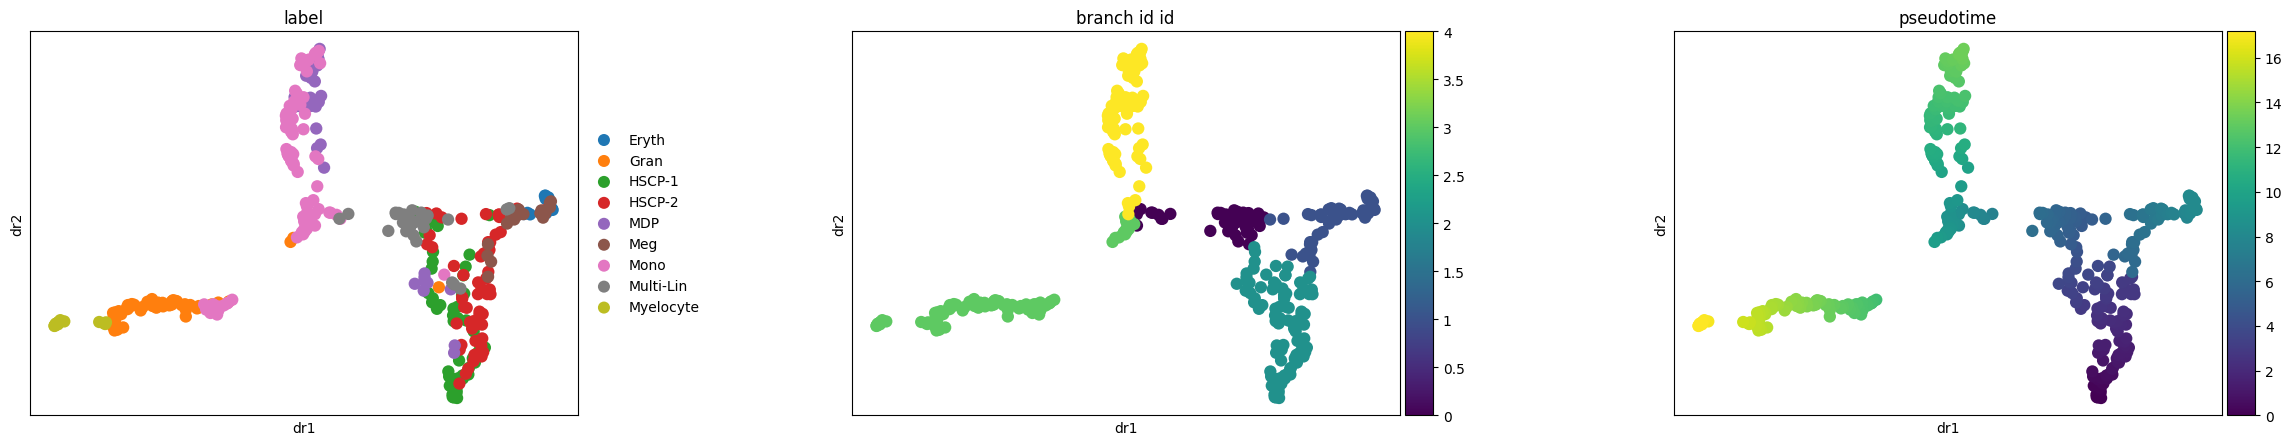

In [9]:
sc.pl.scatter(adata, color=['label', 'branch_id_id', 'pseudotime'], basis='dr')

In [10]:
adata.write_h5ad("figures/wildtype_start.h5ad")
irf8.write_h5ad("figures/irf8_start.h5ad")
gfi1.write_h5ad("figures/gfi1_start.h5ad")
both.write_h5ad("figures/both_start.h5ad")

## 2.2 Run dynchro

/home/louise/Work/dynchro/src/dynchro/tl/dtw.py:116: ImplicitModificationWarning: Setting element `.obsm['irf8_erythrocytic_irf8_cost']` of view, initializing view as actual.
  reference.obsm[f"{dtw_key}_cost"] = cost
/home/louise/Work/dynchro/src/dynchro/tl/dtw.py:120: ImplicitModificationWarning: Setting element `.obsm['irf8_erythrocytic_irf8_cost']` of view, initializing view as actual.
  query.obsm[f"{dtw_key}_cost"] = cost.T


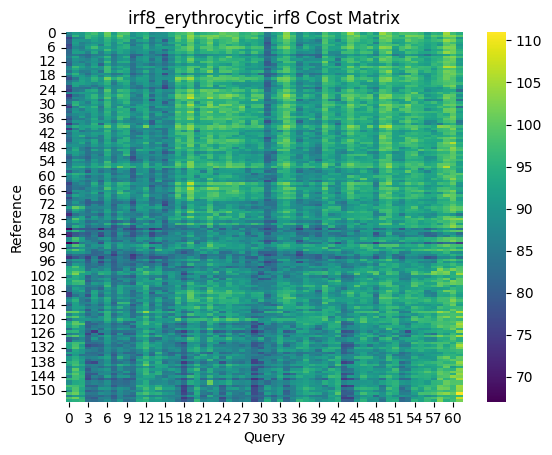

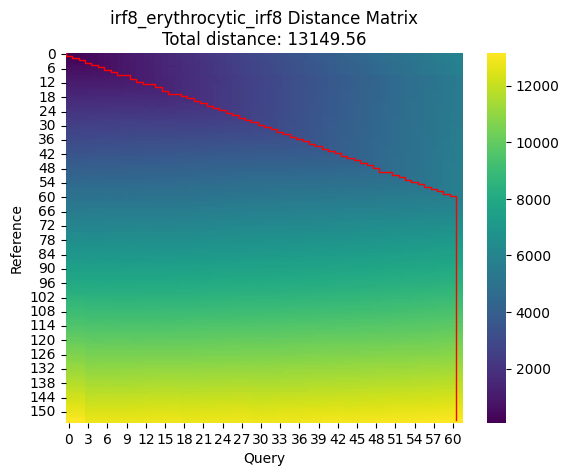

/home/louise/Work/dynchro/src/dynchro/tl/dtw.py:116: ImplicitModificationWarning: Setting element `.obsm['irf8_monocytic_irf8_cost']` of view, initializing view as actual.
  reference.obsm[f"{dtw_key}_cost"] = cost


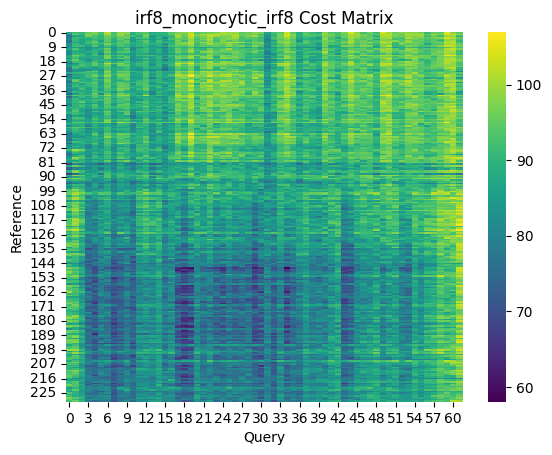

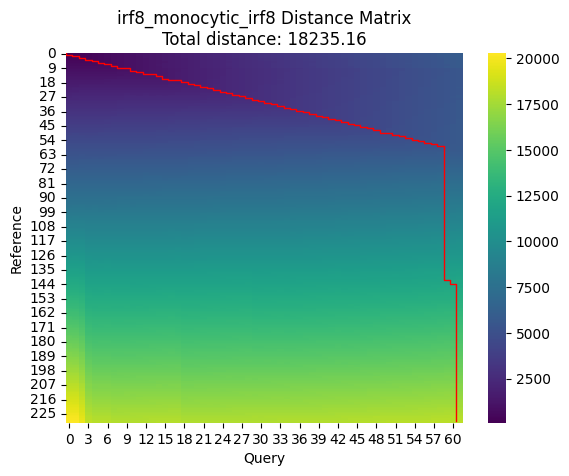

/home/louise/Work/dynchro/src/dynchro/tl/dtw.py:116: ImplicitModificationWarning: Setting element `.obsm['irf8_granulocytic_irf8_cost']` of view, initializing view as actual.
  reference.obsm[f"{dtw_key}_cost"] = cost


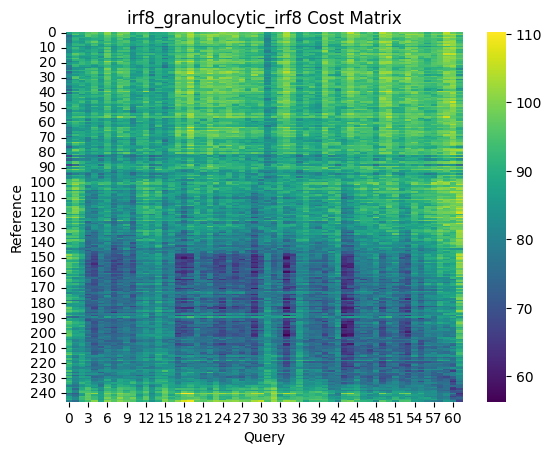

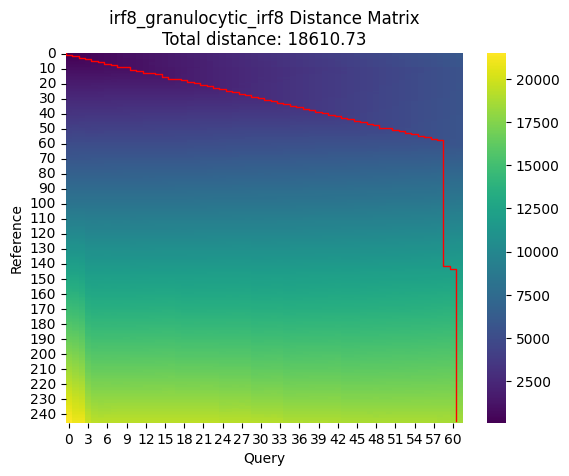

In [12]:
warping_irf8 = dynchro.tl.get_matching_lineages(adata, irf8, "irf8", mode = "copy", plot = True)

In [18]:
wildtypegran.obsm["irf8_granulocytic_irf8_cost"]

array([[ 87.17672929,  91.73427409,  90.67948767, ..., 104.51573557,
         97.43044185,  94.4388251 ],
       [ 83.71101315,  95.93559446,  90.45143871, ..., 103.53622858,
        102.91391673,  99.3423485 ],
       [ 76.03206175,  86.66097942,  87.47434207, ...,  99.06462299,
         99.48471807,  90.36385396],
       ...,
       [ 87.00010487,  81.62073992,  92.58550697, ...,  79.64257936,
         72.23161148,  74.12231458],
       [ 89.35993317,  82.00170125,  92.5046266 , ...,  83.15621376,
         75.46725908,  70.30207999],
       [ 79.7330122 ,  75.41274411,  89.83226233, ...,  85.18289744,
         81.46546921,  67.05182657]], shape=(246, 62))

/home/louise/Work/dynchro/src/dynchro/tl/dtw.py:116: ImplicitModificationWarning: Setting element `.obsm['gfi1_erythrocytic_gfi1_cost']` of view, initializing view as actual.
  reference.obsm[f"{dtw_key}_cost"] = cost
/home/louise/Work/dynchro/src/dynchro/tl/dtw.py:120: ImplicitModificationWarning: Setting element `.obsm['gfi1_erythrocytic_gfi1_cost']` of view, initializing view as actual.
  query.obsm[f"{dtw_key}_cost"] = cost.T


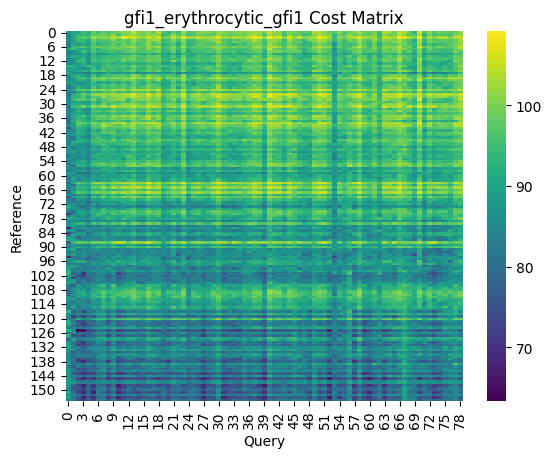

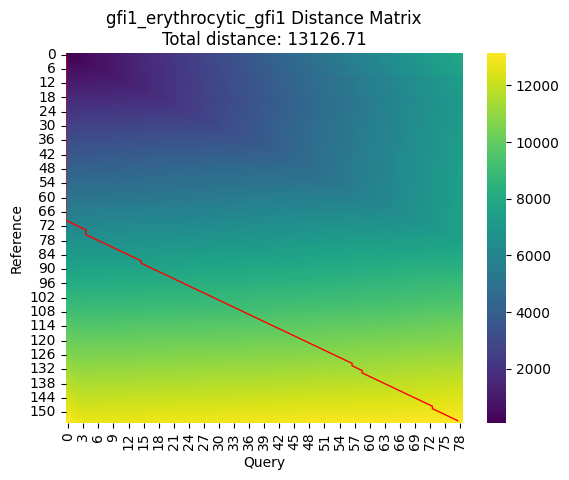

/home/louise/Work/dynchro/src/dynchro/tl/dtw.py:116: ImplicitModificationWarning: Setting element `.obsm['gfi1_monocytic_gfi1_cost']` of view, initializing view as actual.
  reference.obsm[f"{dtw_key}_cost"] = cost


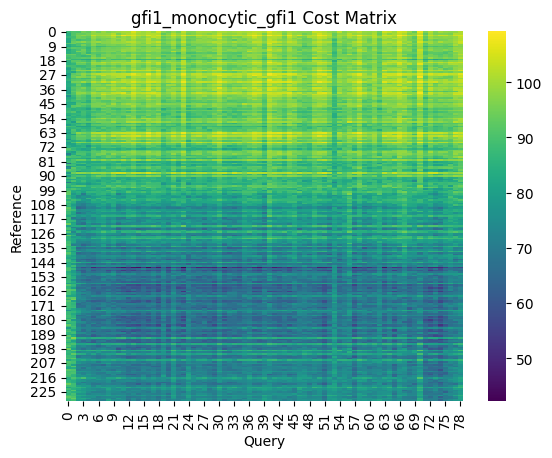

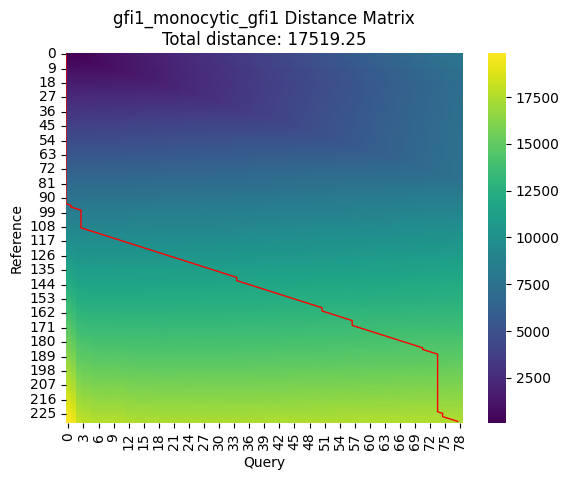

/home/louise/Work/dynchro/src/dynchro/tl/dtw.py:116: ImplicitModificationWarning: Setting element `.obsm['gfi1_granulocytic_gfi1_cost']` of view, initializing view as actual.
  reference.obsm[f"{dtw_key}_cost"] = cost


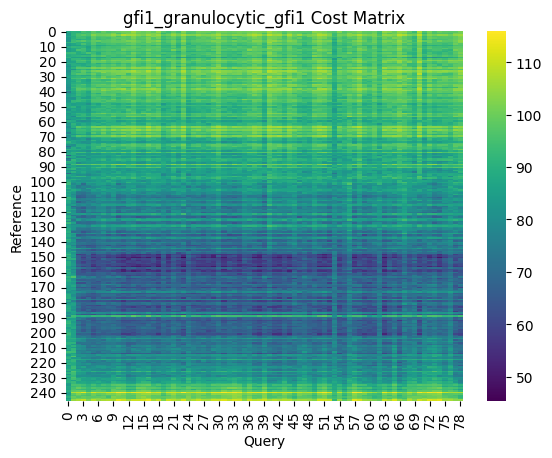

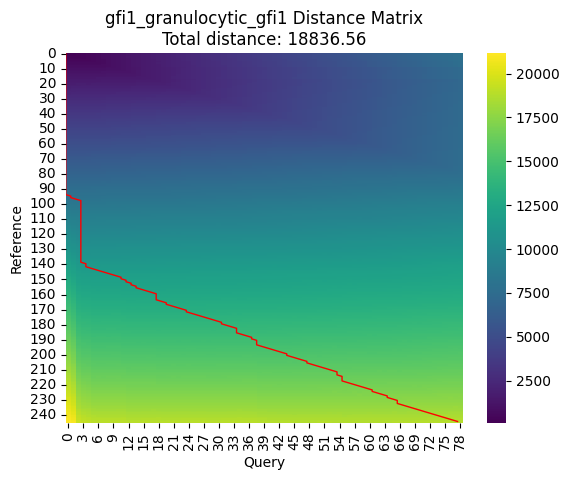

In [22]:
warping_gfi1 = dynchro.tl.get_matching_lineages(adata, gfi1, "gfi1", mode="copy", plot = True)

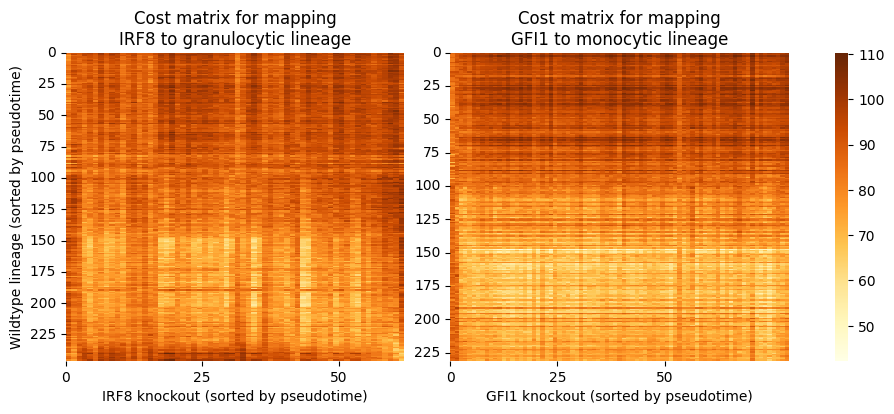

In [23]:
import matplotlib.colors as mcolors
base_color = '#8e7cc3'
colors_gradient = ['#e6e3f0', base_color, '#3a334d']
cmap_gradient = mcolors.LinearSegmentedColormap.from_list('pink_gradient', colors_gradient)
cmap_gradient = "YlOrBr"

wildtypegran = warping_irf8[3][2]
irf8_mapped = warping_irf8[4][0]
wildtypemono = warping_gfi1[3][1]
gfi1_mapped = warping_gfi1[4][0]

irf8_matrix = irf8_mapped.obsm["irf8_granulocytic_irf8_cost"]
gfi1_matrix = gfi1_mapped.obsm["gfi1_monocytic_gfi1_cost"]

vmin = min(np.min(irf8_matrix), np.min(gfi1_matrix))
vmax = max(np.max(irf8_matrix), np.max(gfi1_matrix))

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(10.1, 4), width_ratios = [5, 5, 0.2])

import seaborn as sns
sns.heatmap(wildtypegran.obsm["irf8_granulocytic_irf8_cost"], cmap=cmap_gradient, ax=ax[0], vmin=vmin, vmax=vmax, cbar = False)
ax[0].set_title("Cost matrix for mapping\nIRF8 to granulocytic lineage")
ax[0].set_xlabel("IRF8 knockout (sorted by pseudotime)")
ax[0].set_ylabel("Wildtype lineage (sorted by pseudotime)")
ax[0].set_yticks([0, 25, 50, 75, 100, 125, 150, 175, 200, 225])
ax[0].set_yticklabels([0, 25, 50, 75, 100, 125, 150, 175, 200, 225], rotation=0)
ax[0].set_xticks([0, 25, 50])
ax[0].set_xticklabels([0, 25, 50], rotation=0)

# plt.savefig("figures/2_dynchro_cost_matrices_irf8.pdf", bbox_inches='tight', dpi=300)
# plt.savefig("figures/2_dynchro_cost_matrices_irf8.png", bbox_inches='tight', dpi=300)
# plt.show()
# plt.close()

# fig, ax = plt.subplots(figsize=(4.5, 4))

import seaborn as sns
sns.heatmap(wildtypemono.obsm["gfi1_monocytic_gfi1_cost"], cmap=cmap_gradient, ax=ax[1], vmin=vmin, vmax=vmax, cbar_ax=ax[2])
ax[1].set_title("Cost matrix for mapping\nGFI1 to monocytic lineage")
ax[1].set_xlabel("GFI1 knockout (sorted by pseudotime)")
# ax[1].set_ylabel("Monocytic lineage (sorted by pseudotime)")
ax[1].set_yticks([0, 25, 50, 75, 100, 125, 150, 175, 200, 225])
ax[1].set_yticklabels([0, 25, 50, 75, 100, 125, 150, 175, 200, 225], rotation=0)
ax[1].set_xticks([0, 25, 50])
ax[1].set_xticklabels([0, 25, 50], rotation=0)

plt.savefig("figures/2_dynchro_cost_matrices_gfi1.pdf", bbox_inches='tight', dpi=300)
plt.savefig("figures/2_dynchro_cost_matrices_gfi1.png", bbox_inches='tight', dpi=300)
plt.show()
plt.close()

In [24]:
def flatten(values : list) -> list:
    """
    Flatten a list of lists into a single list.
    """
    flat_list = []

    for sublist in values:
        if isinstance(sublist, list):
            # If the item is a list, extend the result with its contents
            flat_list.extend(sublist)
        else:
            # If the item is not a list, append it directly if it is not None
            if sublist is not None:
                flat_list.append(sublist)

    return flat_list

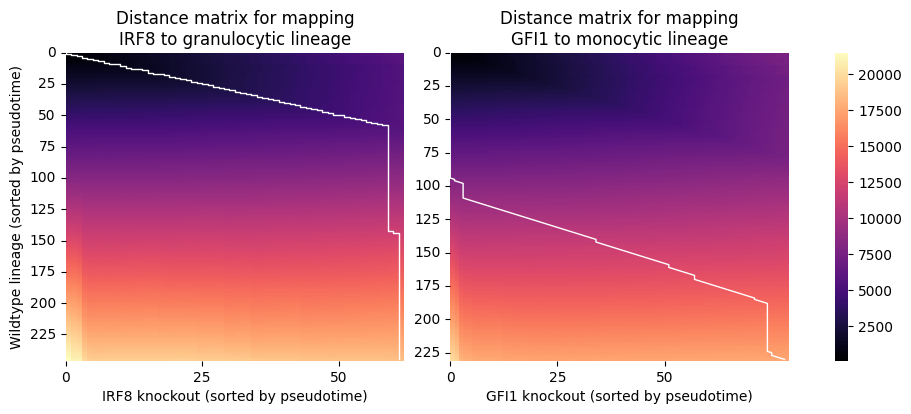

In [25]:
import matplotlib.colors as mcolors
base_color = '#d063a6'
colors_gradient = ['#ead7e1', base_color, '#9e4f7a', '#6d3755']
cmap_gradient = mcolors.LinearSegmentedColormap.from_list('pink_gradient', colors_gradient)
cmap_gradient = "magma"

wildtypegran = warping_irf8[3][2]
irf8_mapped = warping_irf8[4][0]
wildtypemono = warping_gfi1[3][1]
gfi1_mapped = warping_gfi1[4][0]

irf8_matrix = wildtypegran.obsm["irf8_granulocytic_irf8_D"]
gfi1_matrix = wildtypemono.obsm["gfi1_monocytic_gfi1_D"]

vmin = min(np.min(irf8_matrix), np.min(gfi1_matrix))
vmax = max(np.max(irf8_matrix), np.max(gfi1_matrix))

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(10.1, 4), width_ratios = [5, 5, 0.2])

import seaborn as sns
sns.heatmap(irf8_matrix, cmap=cmap_gradient, ax=ax[0], vmin=vmin, vmax=vmax, cbar = False)
path1 = flatten(wildtypegran.obs[f"irf8_granulocytic_irf8_path"])
path2 = flatten(irf8_mapped.obs[f"irf8_granulocytic_irf8_path"])
ax[0].plot(path1, path2, color='white', linewidth=1)
ax[0].set_title("Distance matrix for mapping\nIRF8 to granulocytic lineage")
ax[0].set_xlabel("IRF8 knockout (sorted by pseudotime)")
ax[0].set_ylabel("Wildtype lineage (sorted by pseudotime)")
ax[0].set_yticks([0, 25, 50, 75, 100, 125, 150, 175, 200, 225])
ax[0].set_yticklabels([0, 25, 50, 75, 100, 125, 150, 175, 200, 225], rotation=0)
ax[0].set_xticks([0, 25, 50])
ax[0].set_xticklabels([0, 25, 50], rotation=0)

# plt.savefig("figures/2_dynchro_dist_matrices_irf8.pdf", bbox_inches='tight', dpi=300)
# plt.savefig("figures/2_dynchro_dist_matrices_irf8.png", bbox_inches='tight', dpi=300)
# plt.show()
# plt.close()

# fig, axes = plt.subplots(figsize=(4.5, 4))
# also have axes for the colorbar
# fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(5.1, 4), width_ratios = [1, 0.03])

import seaborn as sns
sns.heatmap(gfi1_matrix, cmap=cmap_gradient, ax=ax[1], vmin=vmin, vmax=vmax, cbar_ax=ax[2])
path1 = flatten(wildtypemono.obs[f"gfi1_monocytic_gfi1_path"])
path2 = flatten(gfi1_mapped.obs[f"gfi1_monocytic_gfi1_path"])
ax[1].plot(path1, path2, color='white', linewidth=1)
ax[1].set_title("Distance matrix for mapping\nGFI1 to monocytic lineage")
ax[1].set_xlabel("GFI1 knockout (sorted by pseudotime)")
# ax[1].set_ylabel("Monocytic lineage (sorted by pseudotime)")
ax[1].set_yticks([0, 25, 50, 75, 100, 125, 150, 175, 200, 225])
ax[1].set_yticklabels([0, 25, 50, 75, 100, 125, 150, 175, 200, 225], rotation=0)
ax[1].set_xticks([0, 25, 50])
ax[1].set_xticklabels([0, 25, 50], rotation=0)

plt.savefig("figures/2_dynchro_dist_matrices_gfi1.pdf", bbox_inches='tight', dpi=300)
plt.savefig("figures/2_dynchro_dist_matrices_gfi1.png", bbox_inches='tight', dpi=300)
plt.show()
plt.close()

/home/louise/Work/dynchro/src/dynchro/tl/dtw.py:116: ImplicitModificationWarning: Setting element `.obsm['both_erythrocytic_both_cost']` of view, initializing view as actual.
  reference.obsm[f"{dtw_key}_cost"] = cost
/home/louise/Work/dynchro/src/dynchro/tl/dtw.py:120: ImplicitModificationWarning: Setting element `.obsm['both_erythrocytic_both_cost']` of view, initializing view as actual.
  query.obsm[f"{dtw_key}_cost"] = cost.T


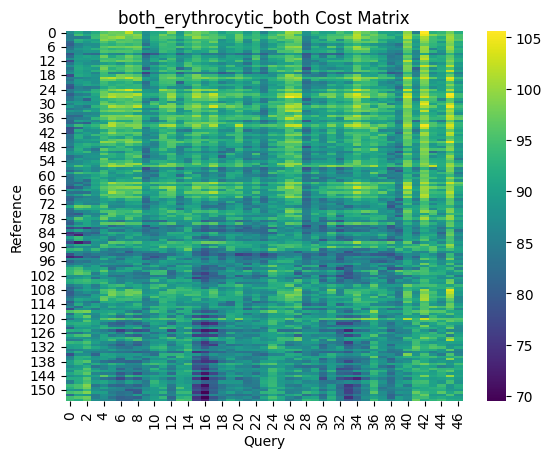

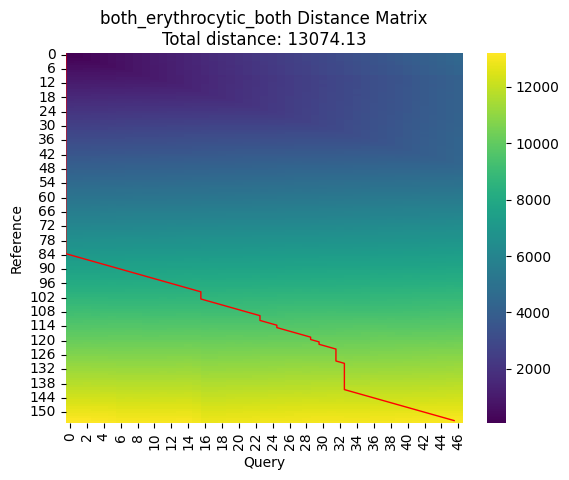

/home/louise/Work/dynchro/src/dynchro/tl/dtw.py:116: ImplicitModificationWarning: Setting element `.obsm['both_monocytic_both_cost']` of view, initializing view as actual.
  reference.obsm[f"{dtw_key}_cost"] = cost


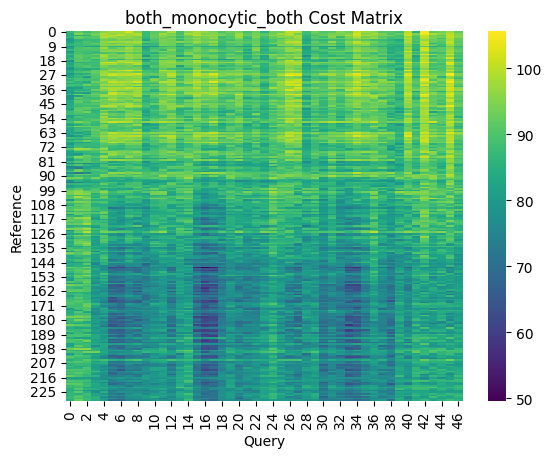

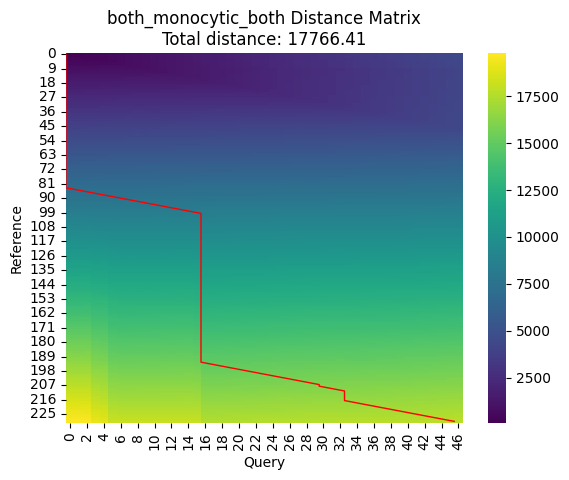

/home/louise/Work/dynchro/src/dynchro/tl/dtw.py:116: ImplicitModificationWarning: Setting element `.obsm['both_granulocytic_both_cost']` of view, initializing view as actual.
  reference.obsm[f"{dtw_key}_cost"] = cost


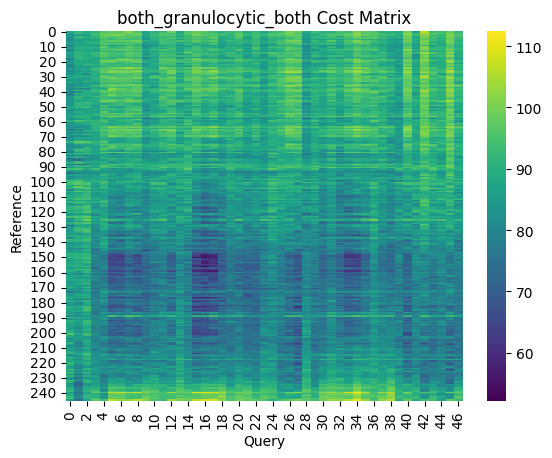

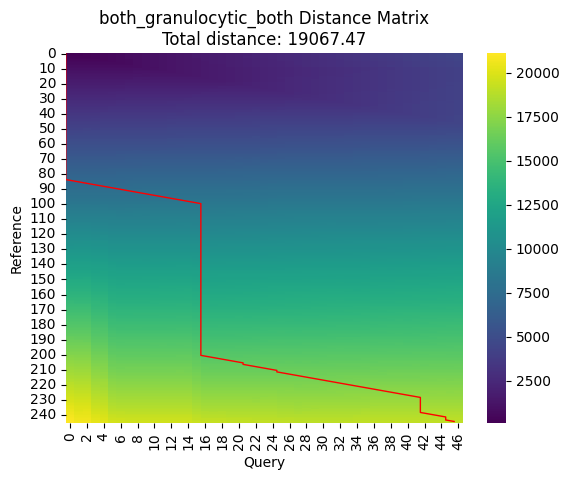

In [26]:
warping_both = dynchro.tl.get_matching_lineages(adata, both, "both", mode="copy", plot = True)

In [27]:
warping_irf8[2], warping_gfi1[2], warping_both[2]

(array([[1.36832027],
        [1.27322724],
        [1.22021599]]),
 array([[1.07200612],
        [0.96001134],
        [0.96925778]]),
 array([[1.79466405],
        [1.63640179],
        [1.64914978]]))

In [28]:
import pickle
with open("figures/2_dynchro_warpings.pkl", "wb") as f:
    pickle.dump((warping_irf8, warping_gfi1, warping_both), f)

## 2.3 Plot average cost

In [78]:
warping_irf8[4][0].obsm["irf8_granulocytic_irf8_D"][-1,60:75]

array([5721.37541416, 5738.67466382, 5831.61297214, 5891.56067661,
       5967.70885553, 6060.98017146, 6135.71849253, 6191.08704036,
       6279.46054823, 6357.84877304, 6441.26098295, 6517.34861139,
       6600.15078156, 6699.4814092 , 6775.89838832])

In [67]:
gran = warping_irf8[3][2]
irf8_warped = warping_irf8[4][0]
dtw_label = "irf8_granulocytic_irf8"
gran = dynchro.tl.avg_cost_path(gran, dtw_key=dtw_label)
irf8_warped = dynchro.tl.avg_cost_path(irf8_warped, dtw_key=dtw_label)

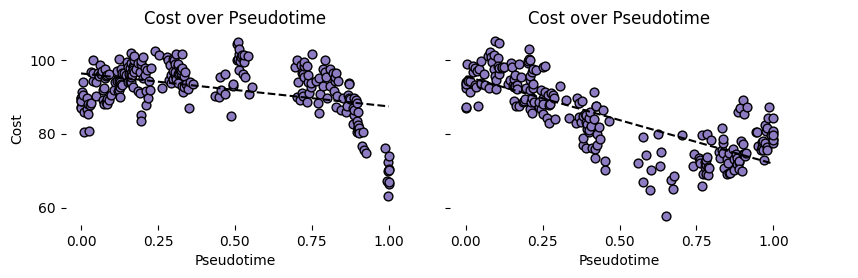

In [302]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(10.1, 2.5), width_ratios = [5, 5, 0.2], sharey = True)

ax = axes[0]

# part 1
gran = warping_irf8[3][2]
gran = dynchro.tl.avg_cost_path(gran, dtw_key="irf8_granulocytic_irf8")
average_cost = gran.obs.sort_values("pseudotime")[f"irf8_granulocytic_irf8_avg_cost"].values
pt = gran.obs.sort_values("pseudotime")["pseudotime"].values
xvals = (pt - pt.min()) / (pt.max() - pt.min())
ax.scatter(xvals, average_cost, label="Average Cost Path", color = "#8e7cc3", alpha=1, edgecolors='k', s=40)

b, a = np.polyfit(xvals[:-1], average_cost[:-1], 1)
ax.plot(xvals, b * xvals + a, color='black', linestyle='--', label='Trend Line (Cost)')

ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
ax.set_xlabel("Pseudotime")
ax.yaxis.set_ticks([60, 80, 100])
ax.set_ylabel("Cost")
ax.set_title("Cost over Pseudotime")

# part 2
ax = axes[1]

mono = warping_gfi1[3][1]
mono = dynchro.tl.avg_cost_path(mono, dtw_key="gfi1_monocytic_gfi1")
average_cost = mono.obs.sort_values("pseudotime")[f"{dtw_label}_avg_cost"].values
pt = mono.obs.sort_values("pseudotime")["pseudotime"].values
xvals = (pt - pt.min()) / (pt.max() - pt.min())

ax.scatter(xvals, average_cost, label="Average Cost Path", color = "#8e7cc3", alpha=1, edgecolors='k', s=40)
b, a = np.polyfit(xvals[:-1], average_cost[:-1], 1)
ax.plot(xvals, b * xvals + a, color='black', linestyle='--', label='Trend Line (Cost)')
ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
ax.set_xlabel("Pseudotime")
ax.yaxis.set_ticks([60, 80, 100])
ax.set_title("Cost over Pseudotime")

# part 3
# get rid of everything
ax = axes[2]
ax.axis('off')

plt.savefig("figures/2_dynchro_cost_path.pdf", bbox_inches='tight', dpi=300)
plt.savefig("figures/2_dynchro_cost_path.png", bbox_inches='tight', dpi=300)
plt.show()
plt.close()

In [172]:
mono = warping_gfi1[3][1]
gfi1_warped = warping_gfi1[4][0]
dtw_label = "gfi1_monocytic_gfi1"
mono = dynchro.tl.avg_cost_path(mono, dtw_key=dtw_label)
gfi1_warped = dynchro.tl.avg_cost_path(gfi1_warped, dtw_key=dtw_label)

# fig, ax = plt.subplots(figsize=(4.5, 2))
ax = axes[1]

average_cost = mono.obs.sort_values("pseudotime")[f"{dtw_label}_avg_cost"].values
pt = mono.obs.sort_values("pseudotime")["pseudotime"].values
# normalize pseudotime to 0-1
xvals = (pt - pt.min()) / (pt.max() - pt.min())

# Plot the average cost path
ax.scatter(xvals, average_cost, label="Average Cost Path", color = "#c27ba0", alpha=0.5)

b, a = np.polyfit(xvals[:-1], average_cost[:-1], 1)
ax.plot(xvals, b * xvals + a, color='black', linestyle='--', label='Trend Line (Cost)')
ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
x0 = ax.get_xlim()[0]
y0 = ax.get_ylim()[0]
# ax.arrow(x0, y0 - 2, 0.4, 0, head_width=2, head_length=0.02, fc='k', ec='k')
ax.set_xlabel("Pseudotime")
# ax.xaxis.set_label_coords(0.2, 0.02)
# ax.yaxis.set_ticks([70, 80, 90])
ax.set_ylabel("Cost")
ax.set_title("Cost over Pseudotime")
# ax.legend(loc = "center right")
plt.savefig("figures/2_dynchro_cost_path_gfi1.pdf", bbox_inches='tight', dpi=300)
plt.savefig("figures/2_dynchro_cost_path_gfi1.png", bbox_inches='tight', dpi=300)
plt.show()
plt.close()

<Figure size 640x480 with 0 Axes>

<Axes: title={'center': 'Average Cost on Path'}, xlabel='Pseudotime', ylabel='Average Cost'>

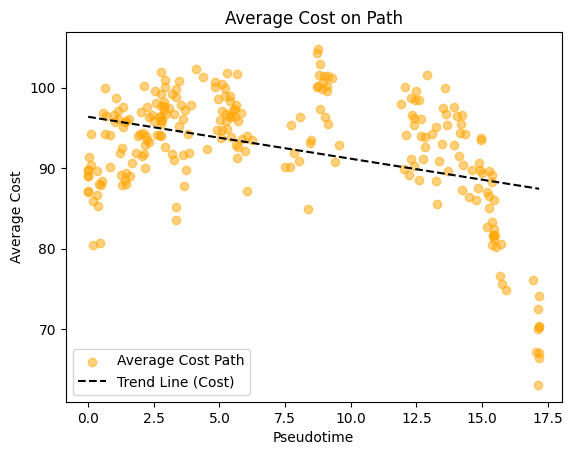

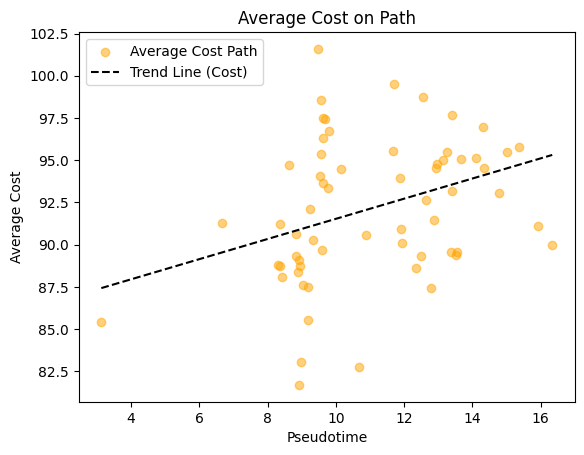

In [87]:
dynchro.pl.plot_avg_cost_path(gran, pseudotime_key="pseudotime", dtw_key=dtw_label)
dynchro.pl.plot_avg_cost_path(irf8_warped, pseudotime_key="pseudotime", dtw_key=dtw_label)

In [88]:
mono = warping_gfi1[3][1]
gfi1_warped = warping_gfi1[4][0]
dtw_label = "gfi1_monocytic_gfi1"
mono = dynchro.tl.avg_cost_path(mono, dtw_key=dtw_label)
gfi1_warped = dynchro.tl.avg_cost_path(gfi1_warped, dtw_key=dtw_label)

<Axes: title={'center': 'Average Cost on Path'}, xlabel='Pseudotime', ylabel='Average Cost'>

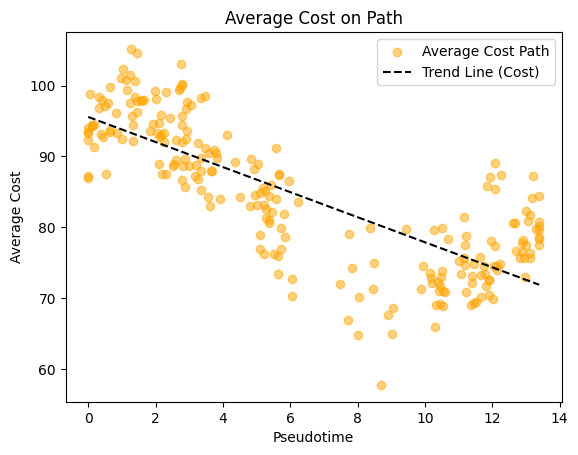

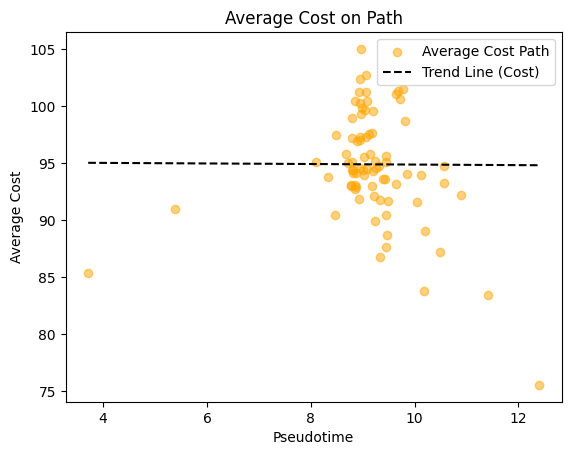

In [89]:
dynchro.pl.plot_avg_cost_path(mono, pseudotime_key="pseudotime", dtw_key=dtw_label)
dynchro.pl.plot_avg_cost_path(gfi1_warped, pseudotime_key="pseudotime", dtw_key=dtw_label)

In [90]:
ery = warping_irf8[3][0]
irf8_warped2 = warping_irf8[4][0]
dtw_label = "irf8_erythrocytic_irf8"
ery = dynchro.tl.avg_cost_path(ery, dtw_key=dtw_label)
irf8_warped2 = dynchro.tl.avg_cost_path(irf8_warped2, dtw_key=dtw_label)

<Axes: title={'center': 'Average Cost on Path'}, xlabel='Pseudotime', ylabel='Average Cost'>

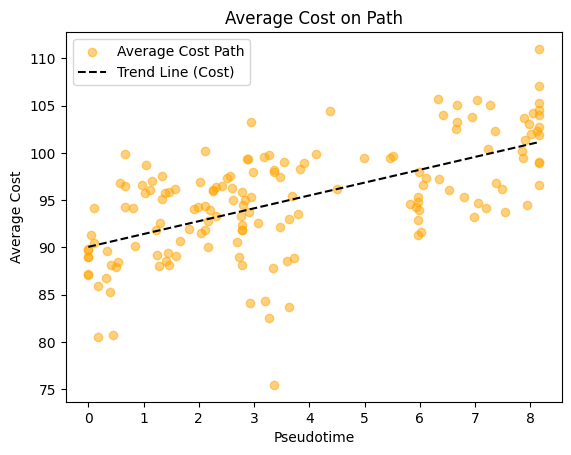

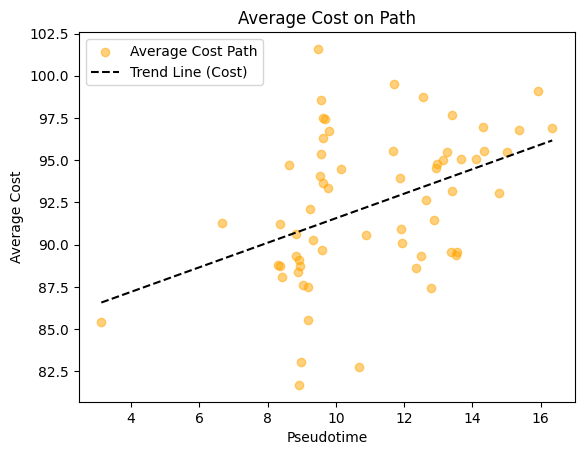

In [91]:
dynchro.pl.plot_avg_cost_path(ery, pseudotime_key="pseudotime", dtw_key=dtw_label)
dynchro.pl.plot_avg_cost_path(irf8_warped2, pseudotime_key="pseudotime", dtw_key=dtw_label)


## 2.4 Plot warping

In [42]:
wt_irf8 = warping_irf8[3][2]

warped_irf8 = warping_irf8[4][0]
erythrocytic = warping_irf8[3][0]
monocytic = warping_gfi1[3][1]
granulocytic = warping_irf8[3][2]

In [43]:
erythrocytic = warping_irf8[3][0]
monocytic = warping_gfi1[3][1]
granulocytic = warping_irf8[3][2]

/home/louise/Work/dynchro/src/dynchro/pl/warping.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ds1_x = norm(warped_datasets[0].obs[pseudotime_key])[warping2]
/home/louise/Work/dynchro/src/dynchro/pl/warping.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ds2_x = norm(warped_datasets[1].obs[pseudotime_key])[warping1]
/home/louise/Work/dynchro/src/dynchro/pl/warping.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


<Axes: xlabel='Pseudotime'>

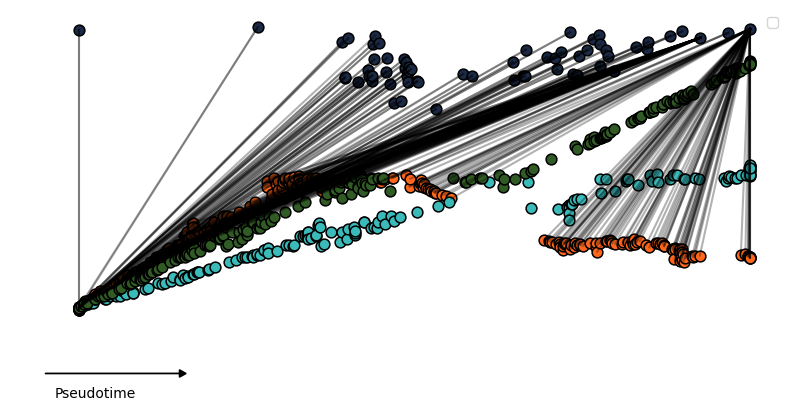

In [44]:
dynchro.pl.plot_warping(
    warped_datasets = [granulocytic, warped_irf8],
    extra_datasets = [erythrocytic, monocytic],
    dtw_key = "irf8_granulocytic_irf8",
    dimred_key = "X_vis_umap"
)

In [45]:
def norm(sequence: np.ndarray) -> np.ndarray:
    """
    Normalize a sequence so that each element lies between 0 and 1.
    """
    return (sequence - np.min(sequence)) / (np.max(sequence) - np.min(sequence))


In [46]:
def plot_warping(
        warped_datasets,
        extra_datasets = None,
        pseudotime_key: str = "pseudotime",
        dtw_key: str = "dtw",
        dimred_key: str = "X_umap",
        yshift = 0,
        ax = None,
):
# fix legends as well
    if ax is None:
        fig, ax = plt.subplots(figsize=(10.1, 3))

    # check only two warped datasets are provided
    assert  len(warped_datasets) <= 2, "Only two warped datasets are supported for plotting."

    # colors = ["#ff681c", "#1b2944", "#3abbba", "#315b25"]
    colors = ['#6fa8dc','#93c47d','#ffc000','#c5504b','#c27ba0','#a64d79','#8e7cc3','#34495e']
    datasets = warped_datasets + extra_datasets if extra_datasets else warped_datasets

    yshifts = [yshift] + [0] * (len(datasets) - 1)
    print(yshifts)
    for dataset, color, yshift_ in zip(datasets, colors, yshifts):
        print(yshift_)
        dimred = dataset.obsm[dimred_key]
        pseudotime = norm(dataset.obs[pseudotime_key])
        ax.scatter(pseudotime, dimred[:, 1] + yshift_, c=color, edgecolors="black", linewidths=1.1, s=60)

    warping1 = flatten(warped_datasets[0].obs[f"{dtw_key}_path"])
    warping2 = flatten(warped_datasets[1].obs[f"{dtw_key}_path"])

    ds1_x = norm(warped_datasets[0].obs[pseudotime_key])[warping2]
    ds1_y = warped_datasets[0].obsm[dimred_key][warping2, 1] + yshifts[0]
    ds2_x = norm(warped_datasets[1].obs[pseudotime_key])[warping1]
    ds2_y = warped_datasets[1].obsm[dimred_key][warping1, 1]

    for x1, y1, x2, y2 in zip(ds1_x, ds1_y, ds2_x, ds2_y):
        ax.plot([x1, x2], [y1, y2], color='black', alpha = 0.2)

    ax.legend()

    ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
    x0 = ax.get_xlim()[0]
    y0 = ax.get_ylim()[0]

    ax.arrow(x0, y0 - 2, 0.2, 0, head_width=0.3, head_length=0.01, fc='k', ec='k')

    ax.set_xlabel("Pseudotime")
    ax.xaxis.set_label_coords(0.11, 0.02)

    ax.set_xticks([])
    ax.set_yticks([])

    ax.legend()

    return ax


[-15, 0, 0, 0]
-15
0
0
0


/tmp/ipykernel_962617/3691110444.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ds1_x = norm(warped_datasets[0].obs[pseudotime_key])[warping2]
/tmp/ipykernel_962617/3691110444.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ds2_x = norm(warped_datasets[1].obs[pseudotime_key])[warping1]
/tmp/ipykernel_962617/3691110444.py:40: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/tmp/ipykernel_962617/3691110444.py:54: UserWarning: No artists with labels found to put in legend.  N

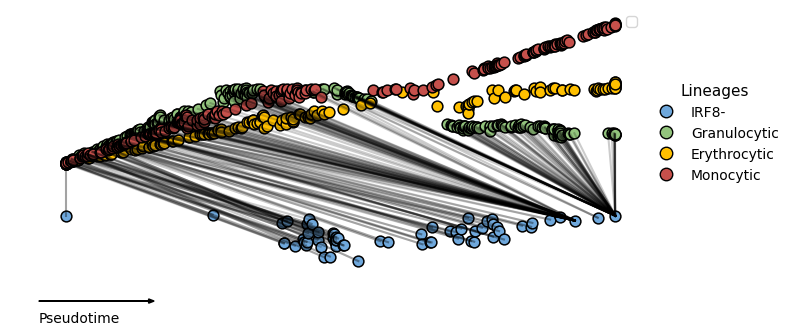

In [47]:
fig, axes = plt.subplots(figsize=(10.1, 4), nrows=1, ncols=2, width_ratios=[9, 1.1])


ax = plot_warping(
    warped_datasets = [warped_irf8, granulocytic],
    extra_datasets = [erythrocytic, monocytic],
    dtw_key = "irf8_granulocytic_irf8",
    dimred_key = "X_vis_umap",
    yshift = -15,
    ax=axes[0]
)
colors = ['#6fa8dc','#93c47d','#ffc000','#c5504b','#c27ba0','#a64d79','#8e7cc3','#34495e']

handles = [plt.Line2D([0], [0], marker='o', markerfacecolor=c, color = "k", markersize = 9, lw = 0) for c in colors[:4]]
labels = ["IRF8-", "Granulocytic", "Erythrocytic", "Monocytic"]

# no spines and ticks
ax = axes[1]
ax.axis('off')

axes[1].legend(handles=handles, labels=labels, frameon=False, loc='center', fontsize=10,
               bbox_to_anchor=(0, 0.6), title="Lineages", title_fontsize=11)

fig.savefig("figures/2_dynchro_warping_irf8.pdf", bbox_inches='tight', dpi=300)
fig.savefig("figures/2_dynchro_warping_irf8.png", bbox_inches='tight', dpi=300)
plt.show()

# # plot colormap as a legend
# handles = [plt.Circle((0, 0), radius=1, color=c) for c in color_map.values()]
# labels = list(color_map.keys())

In [48]:
wt_gfi1 = warping_gfi1[3][2]

warped_GFI1 = warping_gfi1[4][0]
erythrocytic = warping_gfi1[3][0]
monocytic = warping_gfi1[3][1]
granulocytic = warping_gfi1[3][2]

[-8, 0, 0, 0]
-8
0
0
0


/tmp/ipykernel_962617/3691110444.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ds1_x = norm(warped_datasets[0].obs[pseudotime_key])[warping2]
/tmp/ipykernel_962617/3691110444.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ds2_x = norm(warped_datasets[1].obs[pseudotime_key])[warping1]
/tmp/ipykernel_962617/3691110444.py:40: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/tmp/ipykernel_962617/3691110444.py:54: UserWarning: No artists with labels found to put in legend.  N

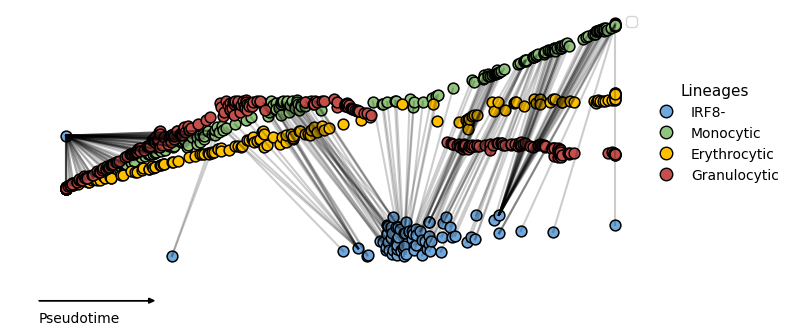

In [49]:
fig, axes = plt.subplots(figsize=(10.1, 4), nrows=1, ncols=2, width_ratios=[9, 1.1])


ax = plot_warping(
    warped_datasets = [warped_GFI1, monocytic],
    extra_datasets = [erythrocytic, granulocytic],
    dtw_key = "gfi1_monocytic_gfi1",
    dimred_key = "X_vis_umap",
    yshift = -8,
    ax=axes[0]
)
colors = ['#6fa8dc','#93c47d','#ffc000','#c5504b','#c27ba0','#a64d79','#8e7cc3','#34495e']

handles = [plt.Line2D([0], [0], marker='o', markerfacecolor=c, color = "k", markersize = 9, lw = 0) for c in colors[:4]]
labels = ["IRF8-", "Monocytic", "Erythrocytic", "Granulocytic"]

# no spines and ticks
ax = axes[1]
ax.axis('off')

axes[1].legend(handles=handles, labels=labels, frameon=False, loc='center', fontsize=10,
               bbox_to_anchor=(0, 0.6), title="Lineages", title_fontsize=11)

fig.savefig("figures/2_dynchro_warping_irf8.pdf", bbox_inches='tight', dpi=300)
fig.savefig("figures/2_dynchro_warping_irf8.png", bbox_inches='tight', dpi=300)
plt.show()

## 2.5 Bootstrap

In [50]:
adata = adata[adata.obs.branch_id_id.isin([0, 1, 3, 4])]
def calculate_distance_irf8(names):
    knockout = irf8[names]
    ri, ci, distances, lin1, lin2 = dynchro.tl.get_matching_lineages(adata, knockout, dtw_key = "irf8")
    return distances[:, 0]

def calculate_distance_gfi1(names):
    knockout = gfi1[names]
    ri, ci, distances, lin1, lin2 = dynchro.tl.get_matching_lineages(adata, knockout, dtw_key = "gfi1")
    return distances[:, 0]

def calculate_distance_both(names):
    knockout = both[names]
    ri, ci, distances, lin1, lin2 = dynchro.tl.get_matching_lineages(adata, knockout, dtw_key = "both")
    return distances[:, 0] 

In [51]:
res_irf8 = stats.bootstrap([irf8.obs_names], calculate_distance_irf8, n_resamples= 100, vectorized=False, axis = 0)
results_irf8 = res_irf8.bootstrap_distribution
res_gfi1 = stats.bootstrap([gfi1.obs_names], calculate_distance_gfi1, n_resamples= 100, vectorized=False, axis = 0)
results_gfi1 = res_gfi1.bootstrap_distribution
res_both = stats.bootstrap([both.obs_names], calculate_distance_both, n_resamples= 100, vectorized=False, axis = 0)
results_both = res_both.bootstrap_distribution

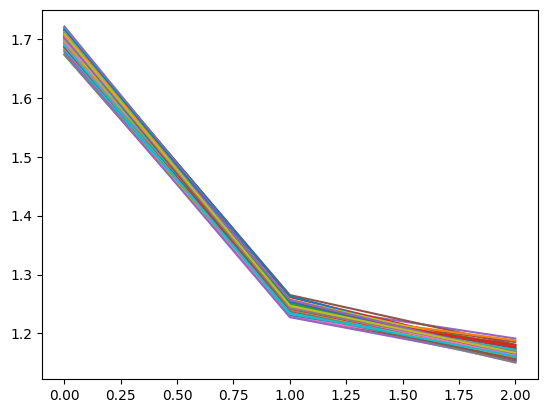

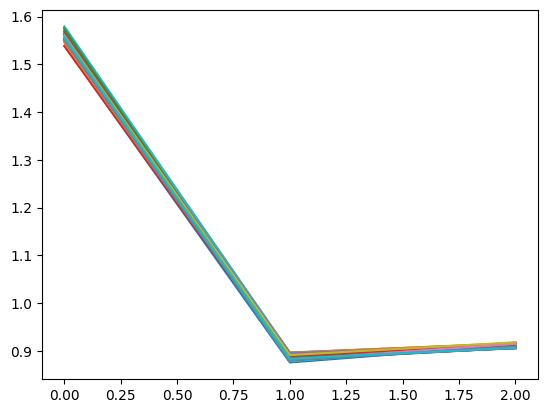

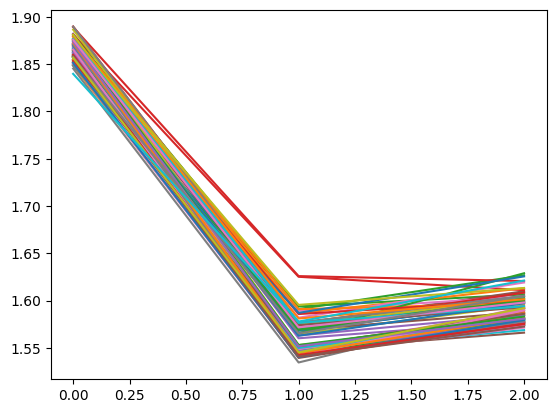

In [52]:
# for each three values, plot a line plot
for i, g, b in zip(results_irf8[0], results_irf8[1], results_irf8[2]):
    plt.plot([i, g, b])

plt.show()

# for each three values, plot a line plot
for i, g, b in zip(results_gfi1[0], results_gfi1[1], results_gfi1[2]):
    plt.plot([i, g, b])

plt.show()
for i, g, b in zip(results_both[0], results_both[1], results_both[2]):
    plt.plot([i, g, b])

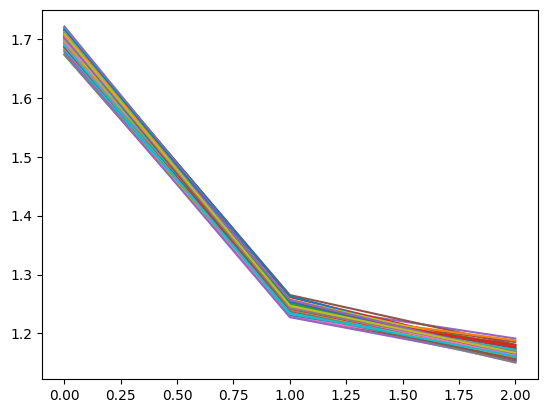

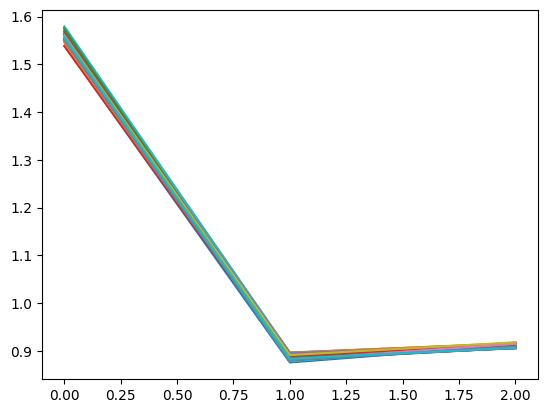

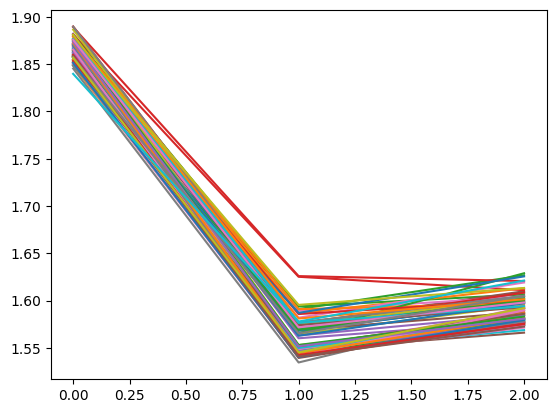

In [53]:
results_irf8 = res_irf8.bootstrap_distribution

# for each three values, plot a line plot
for i, g, b in zip(results_irf8[0], results_irf8[1], results_irf8[2]):
    plt.plot([i, g, b])

plt.show()

results_gfi1 = res_gfi1.bootstrap_distribution

# for each three values, plot a line plot
for i, g, b in zip(results_gfi1[0], results_gfi1[1], results_gfi1[2]):
    plt.plot([i, g, b])

plt.show()
results_both = res_both.bootstrap_distribution

for i, g, b in zip(results_both[0], results_both[1], results_both[2]):
    plt.plot([i, g, b])

In [59]:
irf8_data = pd.DataFrame({"erythrocytic": results_irf8[0], "monocytic": results_irf8[1], "granulocytic": results_irf8[2]})
irf8_data

,erythrocytic,monocytic,granulocytic
0,1.711326,1.243866,1.162318
1,1.696806,1.245345,1.160215
2,1.673810,1.236189,1.166117
3,1.699570,1.241608,1.162604
4,1.696326,1.249467,1.191394
...,...,...,...
95,1.705739,1.236364,1.156363
96,1.706217,1.244724,1.162057
97,1.709383,1.242667,1.168834
98,1.708240,1.247191,1.167000


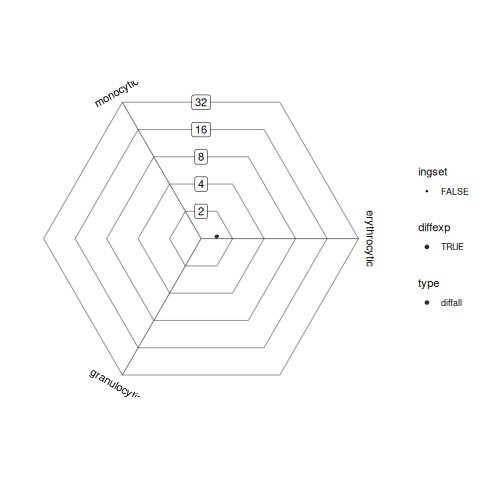

In [72]:
%%R -i irf8_data
library(triwise)
coord <- transformBarycentric(irf8_data)
plotDotplot(coord)

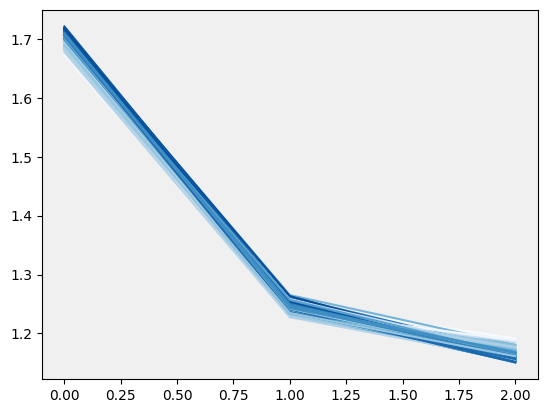

In [88]:
colormap = plt.get_cmap("Blues")

differences = []
for index, (i, g, b) in enumerate(zip(results_irf8[0], results_irf8[1], results_irf8[2])):
    differences.append(max(i, g, b) - min(i, g, b))

normalize_differences = (differences - np.min(differences)) / (np.max(differences) - np.min(differences))

for index, (i, g, b) in enumerate(zip(results_irf8[0], results_irf8[1], results_irf8[2])):
    plt.plot([i, g, b], color=colormap(normalize_differences[index]))

ax = plt.gca()
ax.set_facecolor("#f0f0f0") # very light grey

plt.show()

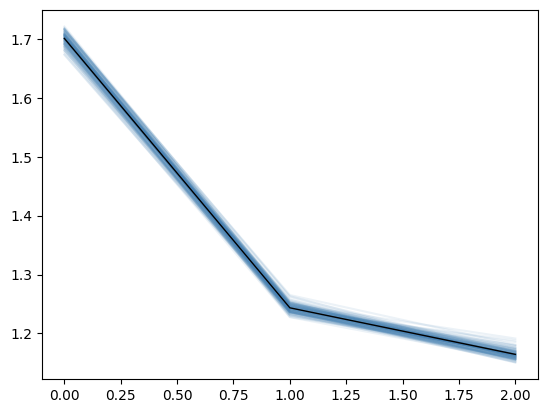

In [102]:
colormap = plt.get_cmap("Blues")

# differences = []
# for index, (i, g, b) in enumerate(zip(results_irf8[0], results_irf8[1], results_irf8[2])):
#     differences.append(max(i, g, b) - min(i, g, b))

# normalize_differences = (differences - np.min(differences)) / (np.max(differences) - np.min(differences))

for index, (i, g, b) in enumerate(zip(results_irf8[0], results_irf8[1], results_irf8[2])):
    plt.plot([i, g, b], color="#4682B4", alpha = 0.1)#colormap(normalize_differences[index]))

avg0 = np.mean(results_irf8[0])
avg1 = np.mean(results_irf8[1])
avg2 = np.mean(results_irf8[2])
plt.plot([avg0, avg1, avg2], color="black", linewidth=1)

ax = plt.gca()
# ax.set_facecolor("#f0f0f0") # very light grey

plt.show()

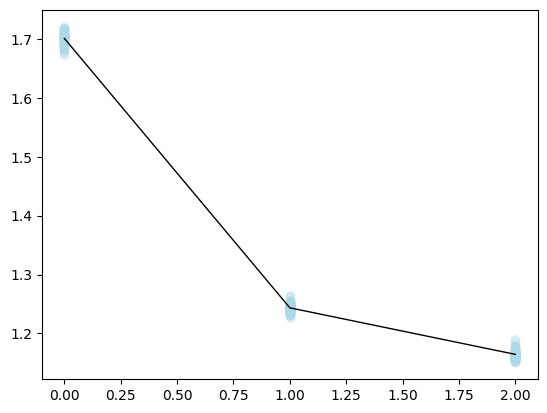

In [92]:
colormap = plt.get_cmap("Blues")

# differences = []
# for index, (i, g, b) in enumerate(zip(results_irf8[0], results_irf8[1], results_irf8[2])):
#     differences.append(max(i, g, b) - min(i, g, b))

# normalize_differences = (differences - np.min(differences)) / (np.max(differences) - np.min(differences))

for index, (i, g, b) in enumerate(zip(results_irf8[0], results_irf8[1], results_irf8[2])):
    # plt.scatter([i, g, b], color="lightblue", alpha = 0.2)#colormap(normalize_differences[index]))
    plt.scatter(0, i, color="lightblue", alpha = 0.2)
    plt.scatter(1, g, color="lightblue", alpha = 0.2)
    plt.scatter(2, b, color="lightblue", alpha = 0.2)

avg0 = np.mean(results_irf8[0])
avg1 = np.mean(results_irf8[1])
avg2 = np.mean(results_irf8[2])
plt.plot([avg0, avg1, avg2], color="black", linewidth=1)

ax = plt.gca()
# ax.set_facecolor("#f0f0f0") # very light grey


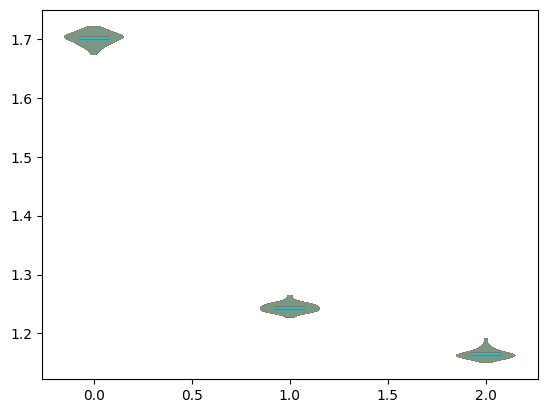

In [98]:
colormap = plt.get_cmap("Blues")

# differences = []
# for index, (i, g, b) in enumerate(zip(results_irf8[0], results_irf8[1], results_irf8[2])):
#     differences.append(max(i, g, b) - min(i, g, b))

# normalize_differences = (differences - np.min(differences)) / (np.max(differences) - np.min(differences))

for index, (i, g, b) in enumerate(zip(results_irf8[0], results_irf8[1], results_irf8[2])):
    # plt.plot([i, g, b], color="lightblue", alpha = 0.2)#colormap(normalize_differences[index]))
    plt.violinplot([results_irf8[0], results_irf8[1], results_irf8[2]], positions=[0, 1, 2], showmeans=True, showmedians=False, showextrema=False, widths=0.3, points=100)

# avg0 = np.mean(results_irf8[0])
# avg1 = np.mean(results_irf8[1])
# avg2 = np.mean(results_irf8[2])
# plt.plot([avg0, avg1, avg2], color="black", linewidth=1)

# ax = plt.gca()
# ax.set_facecolor("#f0f0f0") # very light grey


In [308]:
irf8_data = pd.DataFrame({"erythrocytic": results_irf8[0], "monocytic": results_irf8[1], "granulocytic": results_irf8[2], "id": range(len(results_irf8[0]))}).melt(id_vars = "id")
# rename variable to branch and value to normalised distance
irf8_data = irf8_data.rename(columns = {"variable": "branch", "value": "normalised_distance"})
irf8_data

,id,branch,normalised_distance
0,0,erythrocytic,1.704270
1,1,erythrocytic,1.706515
2,2,erythrocytic,1.689762
3,3,erythrocytic,1.719147
4,4,erythrocytic,1.687422
...,...,...,...
295,95,granulocytic,1.190861
296,96,granulocytic,1.174338
297,97,granulocytic,1.169583
298,98,granulocytic,1.155448


In [309]:
gfi1_data = pd.DataFrame({"erythrocytic": results_gfi1[0], "monocytic": results_gfi1[1], "granulocytic": results_gfi1[2], "id": range(len(results_gfi1[0]))}).melt(id_vars = "id")
# rename variable to branch and value to normalised distance
gfi1_data = gfi1_data.rename(columns = {"variable": "branch", "value": "normalised_distance"})
gfi1_data

,id,branch,normalised_distance
0,0,erythrocytic,1.550601
1,1,erythrocytic,1.555477
2,2,erythrocytic,1.545778
3,3,erythrocytic,1.559528
4,4,erythrocytic,1.561743
...,...,...,...
295,95,granulocytic,0.908318
296,96,granulocytic,0.907923
297,97,granulocytic,0.906252
298,98,granulocytic,0.917291


In [310]:
both_data = pd.DataFrame({"erythrocytic": results_both[0], "monocytic": results_both[1], "granulocytic": results_both[2], "id": range(len(results_both[0]))}).melt(id_vars = "id")
# rename variable to branch and value to normalised distance
both_data = both_data.rename(columns = {"variable": "branch", "value": "normalised_distance"})
both_data

,id,branch,normalised_distance
0,0,erythrocytic,1.859881
1,1,erythrocytic,1.870430
2,2,erythrocytic,1.875792
3,3,erythrocytic,1.858051
4,4,erythrocytic,1.861122
...,...,...,...
295,95,granulocytic,1.572856
296,96,granulocytic,1.575629
297,97,granulocytic,1.576580
298,98,granulocytic,1.594619


In [64]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [66]:
%%R -i irf8_data -i gfi1_data -i both_data

UsageError: %%R is a cell magic, but the cell body is empty. Did you mean the line magic %R (single %)?


In [312]:
%%R
install.packages("ggstatsplot")

* installing *source* package ‘ggstatsplot’ ...
** this is package ‘ggstatsplot’ version ‘0.13.1’
** package ‘ggstatsplot’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** data
*** moving datasets to lazyload DB
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (ggstatsplot)


TypeError: ZMQDisplayPublisher.publish() got an unexpected keyword argument 'source'

In [319]:
%%R -i gfi1_data
library("ggstatsplot")
library("ggplot2")
p1 <- ggwithinstats(gfi1_data, x = branch, y = normalised_distance, title = "GFI1 knockout", xlab = "Branch", ylab = "Normalised distance",
        boxplot.args = list(width = 0),
        violin.args = list(width = 0)
        )
ggsave("gfi1_knockout.pdf", p1, width = 4.5, height = 4.5, dpi = 300)

In [ ]:
%%R -i both_data
p2 <- ggwithinstats(both_data, x = branch, y = normalised_distance, title = "GFI1 and IRF8 knockout", xlab = "Branch", ylab = "Normalised distance")
ggsave("both_knockout.pdf", p2)

Saving 6.67 x 6.67 in image


In [320]:
%%R -i irf8_data
p3 <- ggwithinstats(
        irf8_data, x = branch, y = normalised_distance, title = "IRF8 knockout", xlab = "Branch", ylab = "Normalised distance",
        boxplot.args = list(width = 0),
        violin.args = list(width = 0)
    )
ggsave("irf8_knockout.pdf", p3, width = 4.5, height = 4.5, dpi = 300)